# Preparação de dados

Os dados que serão utilizados estão presentes no dataset [early_stage_diabetes_risk_prediction](https://www.kaggle.com/datasets/tanshihjen/early-stage-diabetes-risk-prediction). Como esperado, eles não se encontram no formato ideal para aplicarmos algoritmos e gerar nossos modelos.



## Limpeza dos dados

Todos os dados presentes no dataset já se encontram preenchidos e sem nenhum tipo de duplicação, sendo assim não foi necessário remover/ preencher nenhum atributo/registro.



## Estratégia para análise do modelo

Em nosso modelo, dar um diagnóstico negativo de diabetes quando na verdade deveria ser positivo, é o cenário que procuramos evitar a todo custo, sendo assim escolhemos utilizar a métrica de _recall_ especialmente olhando para a classificação positiva de diabetes.


## Transformação dos dados

Os dados estão dispostos no formato Yes/No para a maior parte das colunas, Positive/Negative para a classificação de diabetes, Male/Female para coluna de gênero, e números inteiro compreendidos entre 0 - 100 para a idade.

Para transformação de dados usaremos a técnica de Label Encoder para converter os dados para a faixa de 0-1, já os dados de idade manteremos em seu formato natural, veremos mais sobre isso nos tópicos seguintes.

# Descrição dos modelos

O modelo atual que vamos construir é baseado no algoritmo _Naïve Bayes_.

Mais específico estaremos utilizando o objeto `GaussianNB` que assume que os atributos seguem uma distribuição normal para cada classe, como no nosso caso temos o atributo idade e não queremos transformar em faixa etária para não perder detalhes, seguimos com esse algoritmo, em específico para esse valor deu certo pois a idade segue uma distribuição normal.

Para conversão seguiremos a tabela abaixo:

|Original|Convertido|
|---|---|
|Yes|1|
|No|0|
|Male|1|
|Female|0|
|Positive|1|
|Negative|0|

Para a conversão do gênero observamos que os valores escolhidos não afetam o modelo desde que se mantenham consistentes durante todo o processo.

Em nossas pesquisas recentes, calculamos a correlação entre as variáveis presentes no dataset, e apresentamos no formato de heatmap.

![Heatmap correlação variáveis](../../img/heatmap.png)


Ordenando as colunas pelo valor de correlação com a classificação de diabetes temos a seguinte ordem:
1. polyuria
2. polydipsia
3. age
4. gender
5. sudden_weight_loss
6. partial_paresis
7. polyphagia
8. irritability
9. alopecia
10. visual_blurring
11. weakness
12. muscle_stiffness
13. genital_thrush
14. obesity
15. delayed_healing
16. itching

Possuímos muitos atributos, para analizarmos até que ponto o aumento deles influencia a qualidade do modelo usaremos a seguinte estratégia:
1. Selecionar o 1º atributo
2. Treinar o modelo somente com ele
3. Verificar o recall
4. Voltar para etapa 1 mas agora treinar utilizando mais um atributo
5. Seguir o fluxo até finalizar a quantidade de atributos

Usando essa estratégia a cada vez o modelo vai ser treinado e poderemos acompanhar como o aumento do número de atributos influência nossas métricas.

In [3]:
# Bibliotecas necessarias para analizar e demonstrar os resultados
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

[]

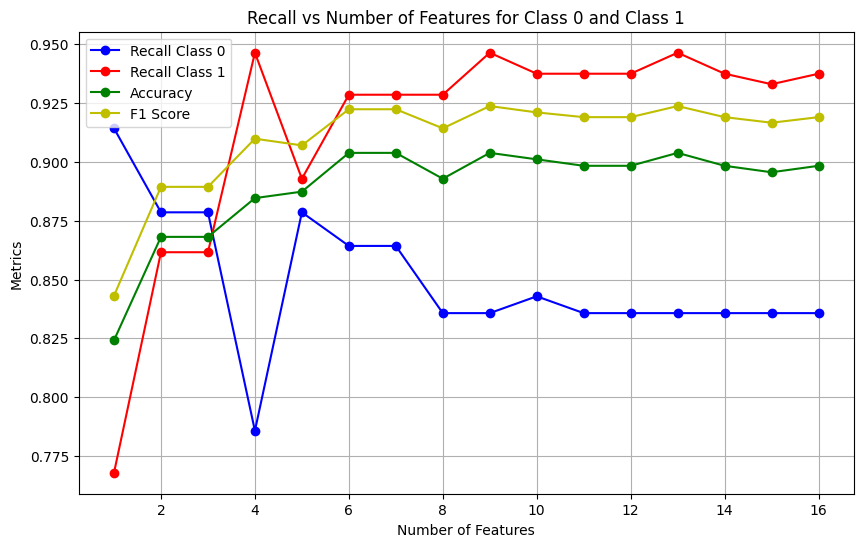

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Colunas do dataset ordenadas pela relevancia em relacao a classificacao
sorted_headers_relevance = [
    'polyuria',
    'polydipsia',
    'age',
    'gender',
    'sudden_weight_loss',
    'partial_paresis',
    'polyphagia',
    'irritability',
    'alopecia',
    'visual_blurring',
    'weakness',
    'muscle_stiffness',
    'genital_thrush',
    'obesity',
    'delayed_healing',
    'itching',
]

# Carregar o CSV
data = pd.read_csv('../dataset-full.csv')

# Renomear os cabeçalhos para snake_case
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

# Tratar a coluna 'gender' manualmente (1 para Male, 2 para Female) o encoder nao suporta nativamente essas nomeclaturas
data['gender'] = data['gender'].map({'Male': 1, 'Female': 2})

# Converter outras colunas descritivas para numéricas com LabelEncoder
label_encoder = LabelEncoder()

# Utiliza o encoder para converter os dados de todas as colunas para numéricos
for column in sorted_headers_relevance + ['class']:
    data[column] = label_encoder.fit_transform(data[column])

# Separar o nosso alvo, resultado final, classificacao de diabetes
y = data['class']


# Armazenar os resultados de recall para serem exibidos posteriormente
# nos graficos
recall_class_0 = []
recall_class_1 = []
model_accuracy = []
f1_score_ls = []
# Iterar sobre os índices das colunas para formar diferentes subconjuntos
for i in range(1, len(sorted_headers_relevance) + 1):
    # Inicializar o modelo Naive Bayes Gaussiano
    gnb = GaussianNB()

    # Selecionar as primeiras i colunas
    X = data[sorted_headers_relevance[:i]]

    # Separar os dados em treino e teste usando estratificação pela "class"
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, stratify=y, random_state=42)

    # Treinar o modelo
    gnb.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    y_pred = gnb.predict(X_test)

    # Avaliar o desempenho do modelo
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Salvar na lista juntamente com a quantidade de atributos utilizados
    recall_class_0.append((i, recall_0))
    recall_class_1.append((i, recall_1))
    model_accuracy.append((i, accuracy))
    f1_score_ls.append((i, f1))


# Controi datasets com as duas metricas
recall_df_0 = pd.DataFrame(recall_class_0, columns=['Number of Features', 'Recall Class 0'])
recall_df_1 = pd.DataFrame(recall_class_1, columns=['Number of Features', 'Recall Class 1'])
accuracy_df = pd.DataFrame(model_accuracy, columns=['Number of Features', 'Accuracy'])
f1_df = pd.DataFrame(f1_score_ls, columns=['Number of Features', 'F1 Score'])

# Cria um grafico
plt.figure(figsize=(10, 6))

# Adiciona as linhas relacionadas com o recall
plt.plot(recall_df_0['Number of Features'], recall_df_0['Recall Class 0'], label='Recall Class 0', marker='o', linestyle='-', color='b')
plt.plot(recall_df_1['Number of Features'], recall_df_1['Recall Class 1'], label='Recall Class 1', marker='o', linestyle='-', color='r')
plt.plot(accuracy_df['Number of Features'], accuracy_df['Accuracy'], label='Accuracy', marker='o', linestyle='-', color='g')
plt.plot(f1_df['Number of Features'], f1_df['F1 Score'], label='F1 Score', marker='o', linestyle='-', color='y')

plt.title('Recall vs Number of Features for Class 0 and Class 1')
plt.xlabel('Number of Features')
plt.ylabel('Metrics')
plt.grid(True)
plt.legend()

plt.plot()

# Avaliação dos modelos criados

## Métricas utilizadas

A escolha do recall como métrica principal para a classificação de diabetes se justifica pelo fato de que, nesse contexto, o objetivo é evitar falsos negativos. Um falso negativo significa que uma pessoa que tem diabetes seria incorretamente classificada como não diabética, o que pode levar a consequências graves, já que ela não receberia o tratamento adequado.

O recall mede a capacidade do modelo de detectar corretamente todos os casos positivos (diabetes), ou seja, a proporção de verdadeiros positivos em relação ao total de casos que realmente são positivos. Um recall alto significa que o modelo consegue identificar a maioria das pessoas com diabetes, reduzindo ao máximo os falsos negativos.

Razões principais para usar o recall:
- Impacto crítico de falsos negativos: No diagnóstico de doenças como o diabetes, deixar de identificar uma pessoa doente pode levar a complicações de saúde sérias e ao agravamento da doença.
- Prioridade na detecção de casos positivos: O recall foca em identificar corretamente todos os casos de diabetes, mesmo que isso aumente a chance de alguns falsos positivos, o que é mais aceitável nesse cenário.
Portanto, o uso do recall é adequado quando a minimização de falsos negativos é a prioridade, como no caso da classificação de doenças como diabetes.

## Discussão dos resultados obtidos

- A inclusão de parâmetros realmente faz a diferença até o 10º atributo (visual_blurring = visão embaçada). A partir desse ponto, as métricas do modelo tendem a se estabilizar, sugerindo que a adição de atributos adicionais pode não trazer benefícios significativos à capacidade preditiva do modelo. Isso indica que a seleção adequada de características é crucial para o desempenho do modelo, e que um número excessivo de atributos pode introduzir ruído, sem contribuir para a melhora nas previsões, ou que até mesmo o conjunto de atributos utilizados não são os mais interessantes, talvez ao cruzar os dados com outra fonte possamos incluir mais atributos relevantes para o modelo.
- Mesmo com o baixo número de registros, a métrica de recall do modelo ficou acima de 80% para a classificação de não diabéticos e 90% para diabéticos. Esses resultados são um bom sinal, pois refletem que o modelo está identificando corretamente a maioria dos casos de diabetes, resultando em poucos falsos negativos no diagnóstico. Isso é especialmente importante em um contexto clínico, onde a detecção precoce de diabetes pode levar a intervenções mais eficazes e à redução de complicações associadas à doença.
- A acurácia de 90% em conjunto com a alta métrica de recall demonstra que o modelo de classificação de diabetes é robusto e eficaz na maioria das previsões. Essa combinação de alta acurácia e recall é indicativa de um modelo que não apenas realiza previsões corretas, mas também é confiável em sua capacidade de identificar corretamente os pacientes diabéticos. Portanto, os resultados sugerem que o modelo pode ser uma ferramenta valiosa para auxiliar na triagem e no diagnóstico de diabetes, contribuindo para uma abordagem mais proativa na gestão da saúde.

# Observações

Embora o modelo Naive Bayes seja uma técnica eficaz e simples para classificação, especialmente em cenários de classificação binária, existem diversas oportunidades para melhorar seu desempenho, mesmo na ausência de hiperparâmetros para ajuste. Aqui estão algumas abordagens que podem ser consideradas:
- Exploração de Diferentes Variantes de Naive Bayes: O Naive Bayes possui várias variantes, como o Gaussian Naive Bayes (que foi utilizado), Multinomial Naive Bayes e Bernoulli Naive Bayes, que são adequadas para diferentes tipos de dados.
- Aumento do Conjunto de Dados: O conjunto de dados é pequeno, a coleta de mais dados pode ser uma maneira eficaz de melhorar o desempenho do modelo.